# Results

In [1]:
import re
import ast
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from metrics import score, recall, ndcg, mrr

In [11]:
def compute_results(trues, preds_annots):
    data = {}
    for k, preds in preds_annots.items():
        data[k] = score(trues, preds, [recall, ndcg, mrr], k=20)
    df = pd.DataFrame(data).transpose()
    df.loc['Mean'] = df.mean()
    return df.round(1)

def select_year(annots, year):
    return {_id: annots[_id] for _id in reading_lists[reading_lists["year"] == year]["id"].to_list() if _id in annots}
    
def compute_results_years(trues, preds_annots):
    data = []
    for year in [2020, 2021, 2022, 2023, 2024]: 
        year_annots = []
        for k, preds in preds_annots.items():
            preds_by_year = select_year(preds, year)
            year_annots.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20))
            data.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20) | {"annotator":k, "year":year})
        data.append(pd.DataFrame(year_annots).mean().to_dict() | {"annotator":"Mean", "year":year})
    df = pd.DataFrame(data).set_index(["year","annotator"])
    return df.round(1)

def load_preds(path):
    preds = defaultdict(lambda: defaultdict(dict))
    for method in ["semantic_scholar", "google_scholar", "gpt-4o"]:
        if method == "gpt-4o":
            file_paths = [(Path(f'{path}/{method}/run{run_i}/preds_annot{annotator_i}.json'), f"annotator{annotator_i}_run{run_i}") for annotator_i in [1,2,3] for run_i in [1,2,3]]
        else:
            file_paths = [(Path(f'{path}/{method}/preds_annot{annotator_i}.json'),f"annotator{annotator_i}")  for annotator_i in [1,2,3]]
        for file_path in file_paths:
            preds[method][file_path[1]] = { id_:[ref["id"] for ref in references] for id_, references in json.loads(file_path[0].read_text()).items()}
    return json.loads(json.dumps(preds))

In [12]:
reading_lists = pd.read_csv("../reading_lists.csv")
reading_lists['reading_list'] = reading_lists['reading_list'].apply(ast.literal_eval)

trues = { id_:[ref["paperId"] for ref in references] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }

preds = load_preds("preds_search_engines/preds")

## Engine comparison using id matching

In [33]:
df1 = compute_results(trues, {"PhD Student":preds["gpt-4o"]["annotator1_run1"], "Expert-Level":preds["gpt-4o"]["annotator2_run1"], "PhD-Level":preds["gpt-4o"]["annotator3_run1"]})
df2 = compute_results(trues, {"PhD Student":preds["gpt-4o"]["annotator2_run2"], "Expert-Level":preds["gpt-4o"]["annotator2_run2"], "PhD-Level":preds["gpt-4o"]["annotator3_run2"]})
df3 = compute_results(trues, {"PhD Student":preds["gpt-4o"]["annotator3_run3"], "Expert-Level":preds["gpt-4o"]["annotator2_run3"], "PhD-Level":preds["gpt-4o"]["annotator3_run3"]})
df = pd.concat([df1, df2, df3], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3"])
average_gpt4_run = ((df["GPT-4o run 1"] + df["GPT-4o run 2"] + df["GPT-4o run 3"]) / 3).round(1);
df_gpt4 = pd.concat([df1, df2, df3, average_gpt4_run], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3", "Average run"])

df1 = compute_results(trues, {"PhD Student":preds["semantic_scholar"]["annotator1"], "Expert-Level":preds["semantic_scholar"]["annotator2"], "PhD-Level":preds["semantic_scholar"]["annotator3"]})
df2 = compute_results(trues, {"PhD Student":preds["google_scholar"]["annotator1"], "Expert-Level":preds["google_scholar"]["annotator2"], "PhD-Level":preds["google_scholar"]["annotator3"]})
df3 = df_gpt4["Average run"]
df_engines = pd.concat([df1, df2, df3], axis=1, keys=["Semantic Scholar", "Google Scholar", "GPT-4o"]); df_engines

#print(df_engines.to_latex(float_format="{:0.1f}".format))

Semantic Scholar           Google Scholar            GPT-4o  \
                       recall ndcg  mrr         recall ndcg   mrr recall   
PhD Student               5.3  3.6  6.2            8.4  7.2  13.0   11.4   
Expert-Level              6.6  4.7  8.4            8.8  7.1  12.7   12.4   
PhD-Level                 4.0  3.2  5.9            5.2  4.7   9.7   10.6   
Mean                      5.3  3.8  6.8            7.5  6.4  11.8   11.5   

                          
              ndcg   mrr  
PhD Student   11.1  21.5  
Expert-Level  12.6  25.5  
PhD-Level     10.4  20.9  
Mean          11.4  22.6

### Comparison by years

In [29]:
df1 = compute_results_years(trues, {"PhD Student":preds["gpt-4o"]["annotator1_run1"], "Expert-Level":preds["gpt-4o"]["annotator2_run1"], "PhD-Level":preds["gpt-4o"]["annotator3_run1"]})
df2 = compute_results_years(trues, {"PhD Student":preds["gpt-4o"]["annotator2_run2"], "Expert-Level":preds["gpt-4o"]["annotator2_run2"], "PhD-Level":preds["gpt-4o"]["annotator3_run2"]})
df3 = compute_results_years(trues, {"PhD Student":preds["gpt-4o"]["annotator3_run3"], "Expert-Level":preds["gpt-4o"]["annotator2_run3"], "PhD-Level":preds["gpt-4o"]["annotator3_run3"]})
df = pd.concat([df1, df2, df3], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3"])
average_gpt4_run = ((df["GPT-4o run 1"] + df["GPT-4o run 2"] + df["GPT-4o run 3"]) / 3).round(1);
df_gpt4_years = pd.concat([df1, df2, df3, average_gpt4_run], axis=1, keys=["GPT-4o run 1", "GPT-4o run 2", "GPT-4o run 3", "Average run"])
df1 = compute_results_years(trues, {"PhD Student":preds["semantic_scholar"]["annotator1"], "Expert-Level":preds["semantic_scholar"]["annotator2"], "PhD-Level":preds["semantic_scholar"]["annotator3"]})
df2 = compute_results_years(trues, {"PhD Student":preds["google_scholar"]["annotator1"], "Expert-Level":preds["google_scholar"]["annotator2"], "PhD-Level":preds["google_scholar"]["annotator3"]})
df3 = df_gpt4_years["Average run"]
df_engines_years = pd.concat([df1, df2, df3], axis=1, keys=["Semantic Scholar", "Google Scholar", "GPT-4o"]); df_engines_years

#print(df_engines_years.to_latex(float_format="{:0.1f}".format))

Semantic Scholar            Google Scholar              \
                            recall ndcg   mrr         recall  ndcg   mrr   
year annotator                                                             
2020 PhD Student               2.4  1.9   4.1            2.1   1.8   4.2   
     Expert-Level              4.8  3.5   6.8            6.2   4.7   7.8   
     PhD-Level                 6.4  5.6  11.9            7.6   8.9  19.6   
     Mean                      4.5  3.7   7.6            5.3   5.1  10.5   
2021 PhD Student               3.0  1.9   2.4            5.6   3.7   3.9   
     Expert-Level              3.4  2.3   3.2            6.7   4.2   4.4   
     PhD-Level                 2.6  2.3   4.4            2.1   2.2   5.3   
     Mean                      3.0  2.2   3.3            4.8   3.4   4.5   
2022 PhD Student               8.4  6.2  12.2           13.9  12.3  25.4   
     Expert-Level              7.4  6.1  11.6            9.9   9.9  23.4   
     PhD-Level                 3.1  1.5   1.5            7.2   5.4   9.2   
     Mean                      6.3  4.6   8.4           10.3   9.2  19.3   
2023 PhD Student               5.5  3.7   3.9            7.4   7.7  16.9   
     Expert-Level              7.1  6.1  14.1            6.9   7.3  14.6   
     PhD-Level                 4.7  3.4   5.7            1.8   2.8   9.6   
     Mean                      5.8  4.4   7.9            5.4   5.9  13.7   
2024 PhD Student               6.9  4.3   8.2            9.8   7.1  10.6   
     Expert-Level             10.8  6.3   8.2            9.3   6.5  11.7   
     PhD-Level                 2.8  3.4   7.0            7.3   4.5   6.3   
     Mean                      6.9  4.7   7.8            8.8   6.0   9.5   

                  GPT-4o              
                  recall  ndcg   mrr  
year annotator                        
2020 PhD Student    12.3  12.6  25.5  
     Expert-Level   15.5  15.7  33.2  
     PhD-Level      12.7  12.8  25.2  
     Mean           13.5  13.7  27.9  
2021 PhD Student    11.2  12.0  27.4  
     Expert-Level   12.7  14.2  34.7  
     PhD-Level       9.8  10.8  25.5  
     Mean           11.2  12.3  29.2  
2022 PhD Student    15.6  15.2  28.7  
     Expert-Level   13.5  14.8  31.4  
     PhD-Level      17.0  16.4  33.3  
     Mean           15.3  15.5  31.1  
2023 PhD Student     3.8   3.5   8.0  
     Expert-Level    5.0   4.1   7.0  
     PhD-Level       3.2   3.2   4.9  
     Mean            4.0   3.6   6.6  
2024 PhD Student     3.5   3.8   7.4  
     Expert-Level    3.4   3.8   7.8  
     PhD-Level       2.9   3.7   7.1  
     Mean            3.3   3.7   7.4

### Recall evolution by years

<Axes: xlabel='year', ylabel='recall'>

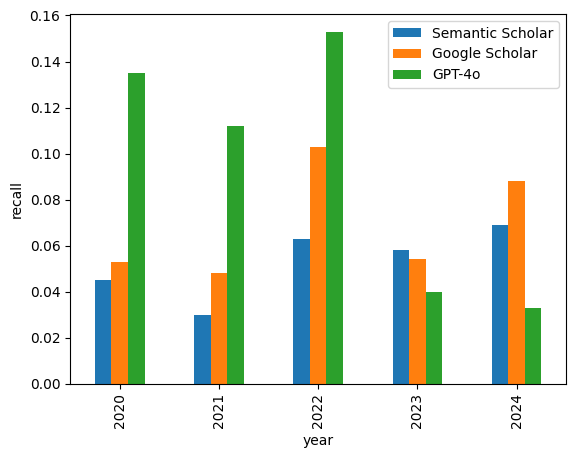

In [30]:
years = [2020, 2021, 2022, 2023, 2024]
data = defaultdict(list)
for i, method in enumerate(["Semantic Scholar", "Google Scholar", "GPT-4o"]):
    data["year"] = years
    for year in years:
        data[method].append(df_engines_years.loc[(year,"Mean")][(method, "recall")]/100)

df = pd.DataFrame(data)
df.plot.bar(x="year", y=["Semantic Scholar", "Google Scholar", "GPT-4o"], ylabel="recall")